# Proyecto: Clasificación de Neumonía (CNN vs ViT)
**Asignatura:** Extensiones de Machine Learning
**Temática:** Adaptación de Modelos (Transfer Learning & Fine-Tuning)

## 1. Configuración del Entorno y Librerías
Importamos las librerías necesarias de PyTorch, Scikit-Learn y herramientas de procesamiento de imágenes. Definimos las constantes globales del proyecto.

In [1]:
import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, utils
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import Counter

# --- CONFIGURACIÓN GLOBAL ---
DATA_DIR = './chest_xray' 

# Parámetros para Transfer Learning (ImageNet)
IMG_SIZE = 224
CHANNELS = 3

# Hiperparámetros de Entrenamiento
BATCH_SIZE = 16  # Reducido para evitar OOM con Vision Transformer
NUM_WORKERS = 2 
SEED = 1234

# Reproducibilidad
torch.manual_seed(SEED)
np.random.seed(SEED)
print(f"Configuración lista. Usando dispositivo: {'cuda' if torch.cuda.is_available() else 'cpu'}")

Configuración lista. Usando dispositivo: cpu


## 2. Gestión de Datos y Split Estratificado
El dataset original tiene una carpeta `val` muy pequeña (16 imágenes) y un fuerte desbalance de clases.

**Estrategia:**
1.  **Fusión:** Ignoramos la división original `train`/`val` y las unimos en un conjunto de desarrollo (`X_dev`).
2.  **Hold-out:** Mantenemos la carpeta `test` original completamente separada.
3.  **Split Estratificado:** Dividimos `X_dev` en un nuevo `TRAIN` (80%) y `VAL` (20%), asegurando que la proporción de Neumonía/Normal se mantenga idéntica en ambos.

In [2]:
def load_data_paths(base_path):
    """
    Recorre las carpetas, fusiona train/val y separa las rutas y etiquetas.
    0: NORMAL, 1: PNEUMONIA
    """
    train_dir = os.path.join(base_path, 'train')
    val_dir = os.path.join(base_path, 'val')
    test_dir = os.path.join(base_path, 'test')

    classes = {'NORMAL': 0, 'PNEUMONIA': 1}
    
    # Listas temporales
    full_train_paths, full_train_labels = [], []
    test_paths, test_labels = [], []

    # 1. FUSIÓN (Train + Val originales)
    for folder in [train_dir, val_dir]:
        for class_name, label in classes.items():
            # Buscamos jpeg y jpg
            files = glob.glob(os.path.join(folder, class_name, '*.jpeg')) 
            files += glob.glob(os.path.join(folder, class_name, '*.jpg'))
            
            full_train_paths.extend(files)
            full_train_labels.extend([label] * len(files))

    # 2. CARGA TEST (Hold-out)
    for class_name, label in classes.items():
        files = glob.glob(os.path.join(test_dir, class_name, '*.jpeg'))
        test_paths.extend(files)
        test_labels.extend([label] * len(files))

    return full_train_paths, full_train_labels, test_paths, test_labels

# Ejecutar carga
if os.path.exists(DATA_DIR):
    X_dev, y_dev, X_test, y_test = load_data_paths(DATA_DIR)
    print(f"Imágenes Desarrollo (Train+Val orig): {len(X_dev)}")
    print(f"Imágenes Test (Hold-out): {len(X_test)}")

    # 3. SPLIT ESTRATIFICADO
    X_train, X_val, y_train, y_val = train_test_split(
        X_dev, y_dev, test_size=0.2, random_state=SEED, stratify=y_dev
    )

    print(f"-> Nuevo Train: {len(X_train)} | Nuevo Val: {len(X_val)}")
    print(f"-> Proporción Train: {Counter(y_train)}")
else:
    print(f"ERROR: No se encuentra la ruta {DATA_DIR}. Por favor sube o descomprime el dataset.")

Imágenes Desarrollo (Train+Val orig): 5232
Imágenes Test (Hold-out): 624
-> Nuevo Train: 4185 | Nuevo Val: 1047
-> Proporción Train: Counter({1: 3106, 0: 1079})


## 3. Definición del Dataset Personalizado
Creamos la clase `PneumoniaDataset` para manejar la carga de imágenes.
**Puntos clave:**
* **Conversión RGB:** Las imágenes médicas son escala de grises (1 canal), pero los modelos pre-entrenados (EfficientNet/ViT) esperan 3 canales. Usamos `.convert('RGB')` para triplicar el canal.

In [3]:
class PneumoniaDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        # Cargar imagen y convertir a RGB (3 canales)
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error cargando imagen: {img_path} - {e}")
            # Retornar una imagen negra en caso de error (o manejar según convenga)
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE))

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

## 4. Estrategia B: Oversampling + Data Augmentation
Dado que la clase `NORMAL` es minoritaria (aprox 1:3), el modelo podría sesgarse.
1.  **WeightedRandomSampler:** Calcula el inverso de la frecuencia de cada clase. Asigna mayor probabilidad de muestreo a las imágenes `NORMAL` para que el batch esté equilibrado.
2.  **Data Augmentation:** Aplicamos transformaciones geométricas solo al conjunto de **Train** para evitar que el modelo memorice las imágenes repetidas por el sampler.

In [4]:
# --- 1. SAMPLER PARA BALANCEO ---
def get_sampler(labels):
    class_counts = Counter(labels)
    # Pesos inversos: menos muestras -> mayor peso
    weight_normal = 1.0 / class_counts[0]
    weight_pneumonia = 1.0 / class_counts[1]
    
    print(f"Pesos -> Normal: {weight_normal:.4f} | Pneumonia: {weight_pneumonia:.4f}")
    
    samples_weights = [weight_normal if label == 0 else weight_pneumonia for label in labels]
    samples_weights = torch.tensor(samples_weights).double()
    
    # Sampler con reemplazo (permite repetir la clase minoritaria)
    sampler = WeightedRandomSampler(
        weights=samples_weights,
        num_samples=len(samples_weights),
        replacement=True
    )
    return sampler

# Generar el sampler solo para el conjunto de TRAIN
train_sampler = get_sampler(y_train)

# --- 2. DATA AUGMENTATION ---
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        # Aumento de datos para evitar overfitting en clases repetidas
        transforms.RandomRotation(15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val_test': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Pesos -> Normal: 0.0009 | Pneumonia: 0.0003


## 5. Instancia de DataLoaders
Generamos los iteradores que alimentarán a la red neuronal.
* **Train:** Usa `sampler`, por lo que `shuffle` debe ser `False`.
* **Val/Test:** Sin sampler ni aumentos, para evaluar el rendimiento real.

In [5]:
# Instanciar Datasets
train_ds = PneumoniaDataset(X_train, y_train, transform=data_transforms['train'])
val_ds = PneumoniaDataset(X_val, y_val, transform=data_transforms['val_test'])
test_ds = PneumoniaDataset(X_test, y_test, transform=data_transforms['val_test'])

# Crear DataLoaders
dataloaders = {
    'train': DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=train_sampler, shuffle=False),
    'val': DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False),
    'test': DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
}

print(f"DataLoaders listos. Batch size: {BATCH_SIZE}")

DataLoaders listos. Batch size: 16


## 6. Sanity Check (Verificación)
Visualizamos un batch de entrenamiento para confirmar:
1.  Que las imágenes tienen el tamaño correcto ($224 \times 224$).
2.  Que el **WeightedSampler** está funcionando (deberíamos ver una mezcla equilibrada de Normal/Neumonía, no solo Neumonía).
3.  Que el **Data Augmentation** está aplicando rotaciones ligeras.

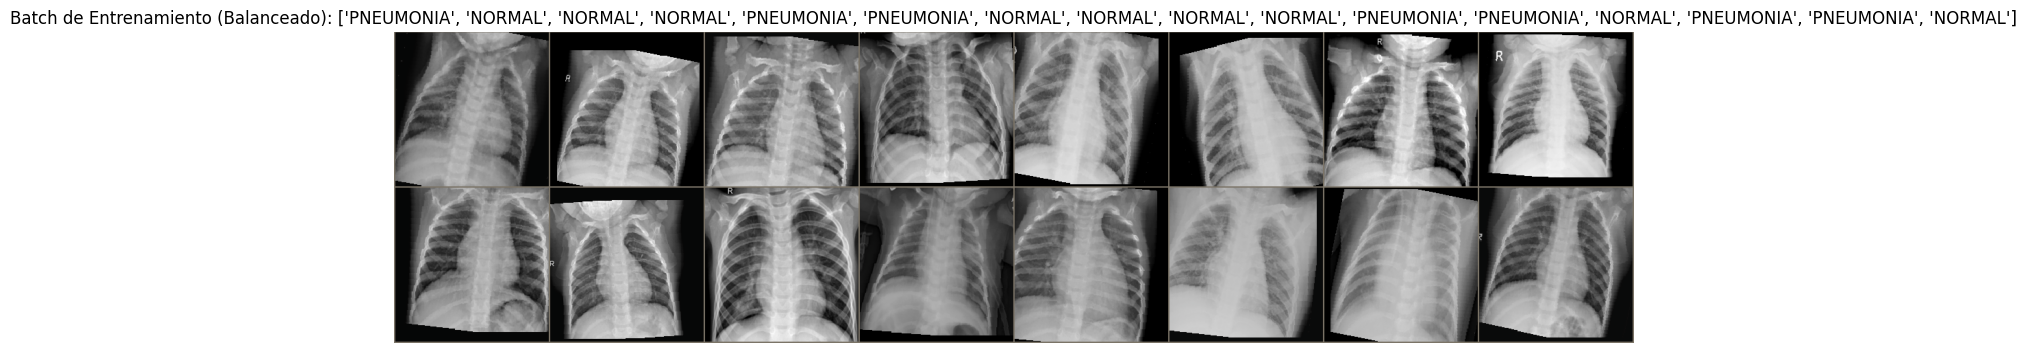

Etiquetas del batch (0=Normal, 1=Pneumonia): [1 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0]


In [7]:
def show_batch(dataloader, class_names):
    images, labels = next(iter(dataloader))
    
    plt.figure(figsize=(16, 8))
    # Desnormalizar para visualizar correctamente (volver a rango 0-1)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    grid_img = utils.make_grid(images, nrow=8, padding=2)
    img_np = grid_img.numpy().transpose((1, 2, 0))
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)
    
    plt.imshow(img_np)
    plt.title(f"Batch de Entrenamiento (Balanceado): {[class_names[x] for x in labels[:16].numpy()]}")
    plt.axis('off')
    plt.show()
    
    print(f"Etiquetas del batch (0=Normal, 1=Pneumonia): {labels.numpy()}")

# Ejecutar visualización
class_names = {0: 'NORMAL', 1: 'PNEUMONIA'}
if os.path.exists(DATA_DIR):
    show_batch(dataloaders['train'], class_names)

## 7. Definición de Arquitecturas (CNN vs Transformer)
Utilizaremos la librería `torchvision` para descargar los pesos pre-entrenados en ImageNet.

**Modelos seleccionados:**
1.  **EfficientNet-B0 (CNN):** Una red convolucional optimizada que busca el equilibrio entre profundidad, ancho y resolución. Es ligera y rápida.
2.  **ViT-Base-16 (Transformer):** Divide la imagen en parches de $16 \times 16$ y los procesa como una secuencia (similar a NLP). Es muy potente pero requiere más datos o regularización.

**Adaptación del Clasificador (The Head):**
Los modelos originales clasifican 1000 clases (perros, coches, etc.). Eliminamos la última capa lineal y la sustituimos por una nueva capa de **2 salidas** (Normal vs Neumonía).

In [8]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models import vit_b_16, ViT_B_16_Weights
import torch.nn as nn

def get_model(model_name, freeze_backbone=True, num_classes=2):
    """
    Carga un modelo pre-entrenado y modifica su capa final.
    
    Args:
        model_name (str): 'efficientnet' o 'vit'
        freeze_backbone (bool): Si es True, congela los pesos (Feature Extraction).
                                Si es False, entrena todo (Fine-Tuning).
    """
    model = None
    weights = None
    
    print(f"Cargando {model_name} pre-entrenado en ImageNet...")
    
    # 1. Cargar la Arquitectura Base
    if model_name == 'efficientnet':
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1
        model = efficientnet_b0(weights=weights)
        
        # Congelar pesos si es necesario (Estrategia Base)
        if freeze_backbone:
            for param in model.features.parameters():
                param.requires_grad = False
        
        # 2. Modificar la Cabeza (Classifier)
        # EfficientNet tiene su clasificador en model.classifier
        # La capa final original es: Linear(in_features=1280, out_features=1000)
        in_features = model.classifier[1].in_features
        
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True), # Mantener dropout original
            nn.Linear(in_features, num_classes)
        )
        
    elif model_name == 'vit':
        weights = ViT_B_16_Weights.IMAGENET1K_V1
        model = vit_b_16(weights=weights)
        
        if freeze_backbone:
            # En ViT congelamos los bloques del encoder
            for param in model.encoder.parameters():
                param.requires_grad = False
        
        # ViT tiene su clasificador en model.heads
        # Original: Linear(in_features=768, out_features=1000)
        in_features = model.heads.head.in_features
        
        model.heads = nn.Sequential(
            nn.Linear(in_features, num_classes)
        )
        
    else:
        raise ValueError("Modelo no soportado. Usa 'efficientnet' o 'vit'")
    
    return model

# Prueba rápida de instanciación (Solo para verificar que no hay errores)
print("--- Prueba de EfficientNet ---")
cnn_model = get_model('efficientnet', freeze_backbone=True)
print(f"Cabeza modificada CNN: {cnn_model.classifier}")

print("\n--- Prueba de Vision Transformer ---")
vit_model = get_model('vit', freeze_backbone=True)
print(f"Cabeza modificada ViT: {vit_model.heads}")

--- Prueba de EfficientNet ---
Cargando efficientnet pre-entrenado en ImageNet...
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\pablo/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100.0%


Cabeza modificada CNN: Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)

--- Prueba de Vision Transformer ---
Cargando vit pre-entrenado en ImageNet...
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\pablo/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth


100.0%


Cabeza modificada ViT: Sequential(
  (0): Linear(in_features=768, out_features=2, bias=True)
)


## 8. Configuración del Entrenamiento
Definimos la función de pérdida y el optimizador.

* **Loss Function:** Usamos `CrossEntropyLoss`. Aunque tenemos un problema binario, usar CrossEntropy con 2 salidas es numéricamente estable y estándar en PyTorch.
* **Optimizador:** Usaremos `AdamW`, que suele funcionar mejor que Adam estándar para Transfer Learning.
* **Class Weights:** Aunque ya estamos balanceando con el Sampler (Estrategia B), en el experimento de **Estrategia A** usaríamos pesos aquí en la Loss. Por ahora, como usamos Sampler, dejamos la Loss estándar.

In [9]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    since = time.time()
    
    # Guardar los mejores pesos (basado en Recall o Loss de validación)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1000.0
    
    # Historial para gráficas
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    print(f"Iniciando entrenamiento en: {device}")
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Cada época tiene fase de entrenamiento y validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0
            
            # Iterar sobre los datos
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + Optimize solo si es train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Guardar historial
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
                # Deep Copy del modelo si mejora la loss
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
        
    time_elapsed = time.time() - since
    print(f'Entrenamiento completado en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Mejor val Loss: {best_loss:.4f}')
    
    # Cargar mejores pesos
    model.load_state_dict(best_model_wts)
    return model, history

## 9. Experimento 1: Entrenamiento de CNN (EfficientNet)
**Estrategia:** Feature Extraction.
**Configuración:**
* **Modelo:** EfficientNet-B0.
* **Optimizador:** AdamW (Learning Rate = 0.001).
* **Épocas:** 5 (Suficiente para ver convergencia rápida en la cabeza).
* **Balanceo:** Gestionado por el `WeightedRandomSampler` definido en el DataLoader.

In [10]:
import torch.optim as optim

# 1. Instanciar el modelo
# freeze_backbone=True -> Solo entrenamos el clasificador final
cnn_model = get_model('efficientnet', freeze_backbone=True)

# 2. Definir función de pérdida (Loss)
# Usamos CrossEntropyLoss estándar porque el balanceo ya lo hace el Sampler
criterion = nn.CrossEntropyLoss()

# 3. Definir Optimizador
# Solo pasamos los parámetros que requieren gradiente (la cabeza)
# Si pasáramos todos, daría error porque el backbone tiene requires_grad=False
optimizer_cnn = optim.AdamW(cnn_model.classifier.parameters(), lr=1e-3)

# 4. ¡Entrenar!
print("\n--- Lanzando Entrenamiento CNN (Feature Extraction) ---")
cnn_model, cnn_history = train_model(
    cnn_model, 
    dataloaders, 
    criterion, 
    optimizer_cnn, 
    num_epochs=5
)

Cargando efficientnet pre-entrenado en ImageNet...

--- Lanzando Entrenamiento CNN (Feature Extraction) ---
Iniciando entrenamiento en: cpu
Epoch 1/5
----------
train Loss: 0.3222 Acc: 0.8710
val Loss: 0.4419 Acc: 0.8032

Epoch 2/5
----------
train Loss: 0.2324 Acc: 0.9111
val Loss: 0.3505 Acc: 0.8491

Epoch 3/5
----------
train Loss: 0.2202 Acc: 0.9204
val Loss: 0.3497 Acc: 0.8481

Epoch 4/5
----------
train Loss: 0.2204 Acc: 0.9137
val Loss: 0.2545 Acc: 0.9016

Epoch 5/5
----------
train Loss: 0.2061 Acc: 0.9190
val Loss: 0.2697 Acc: 0.8921

Entrenamiento completado en 27m 18s
Mejor val Loss: 0.2545


## 10. Visualización de Curvas de Aprendizaje
Es fundamental visualizar si el modelo está aprendiendo o memorizando.
* **Loss:** Debería bajar tanto en Train como en Val.
* **Accuracy:** Debería subir. Si Train sube mucho y Val se estanca, hay Overfitting.

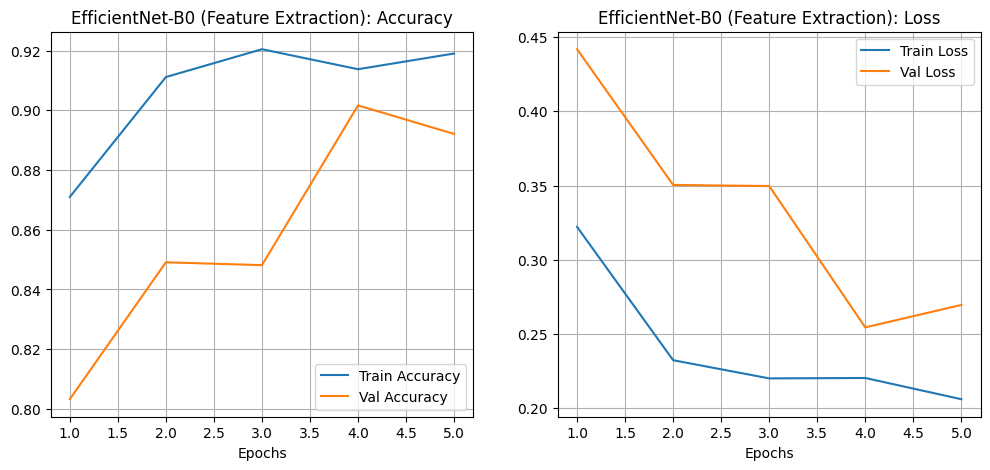

In [11]:
def plot_training_history(history, title="Training History"):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    # Gráfica de Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title}: Accuracy')
    plt.xlabel('Epochs')
    plt.grid(True)

    # Gráfica de Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title}: Loss')
    plt.xlabel('Epochs')
    plt.grid(True)
    
    plt.show()

# Visualizar curvas de la CNN
plot_training_history(cnn_history, title="EfficientNet-B0 (Feature Extraction)")

## 11. Experimento 2: Entrenamiento de Vision Transformer (ViT)
**Arquitectura:** ViT-Base-16.
**Configuración:**
* Divide la imagen en parches de $16 \times 16$.
* **Estrategia:** Feature Extraction (Encoder congelado, solo se entrena la capa lineal final).
* **Desafío:** Los Transformers suelen necesitar muchos más datos para generalizar que las CNNs (falta de *inductive bias*). Veremos si con Transfer Learning es suficiente.

In [12]:
# 1. Instanciar el modelo ViT
# freeze_backbone=True -> Congelamos los bloques de atención (Encoder)
vit_model = get_model('vit', freeze_backbone=True)

# 2. Definir función de pérdida
criterion = nn.CrossEntropyLoss()

# 3. Definir Optimizador
# Los Transformers funcionan mejor con AdamW y Weight Decay (regularización)
optimizer_vit = optim.AdamW(vit_model.heads.parameters(), lr=1e-3, weight_decay=0.01)

# 4. ¡Entrenar!
print("\n--- Lanzando Entrenamiento ViT (Feature Extraction) ---")
print("Nota: Esto puede ser más lento que la CNN...")

vit_model, vit_history = train_model(
    vit_model, 
    dataloaders, 
    criterion, 
    optimizer_vit, 
    num_epochs=5
)

Cargando vit pre-entrenado en ImageNet...

--- Lanzando Entrenamiento ViT (Feature Extraction) ---
Nota: Esto puede ser más lento que la CNN...
Iniciando entrenamiento en: cpu
Epoch 1/5
----------
train Loss: 0.2040 Acc: 0.9223
val Loss: 0.3010 Acc: 0.8758

Epoch 2/5
----------
train Loss: 0.1332 Acc: 0.9477
val Loss: 0.3561 Acc: 0.8558

Epoch 3/5
----------
train Loss: 0.1243 Acc: 0.9536
val Loss: 0.2218 Acc: 0.9150

Epoch 4/5
----------
train Loss: 0.0993 Acc: 0.9615
val Loss: 0.2478 Acc: 0.9112

Epoch 5/5
----------
train Loss: 0.1032 Acc: 0.9582
val Loss: 0.2577 Acc: 0.9045

Entrenamiento completado en 306m 5s
Mejor val Loss: 0.2218


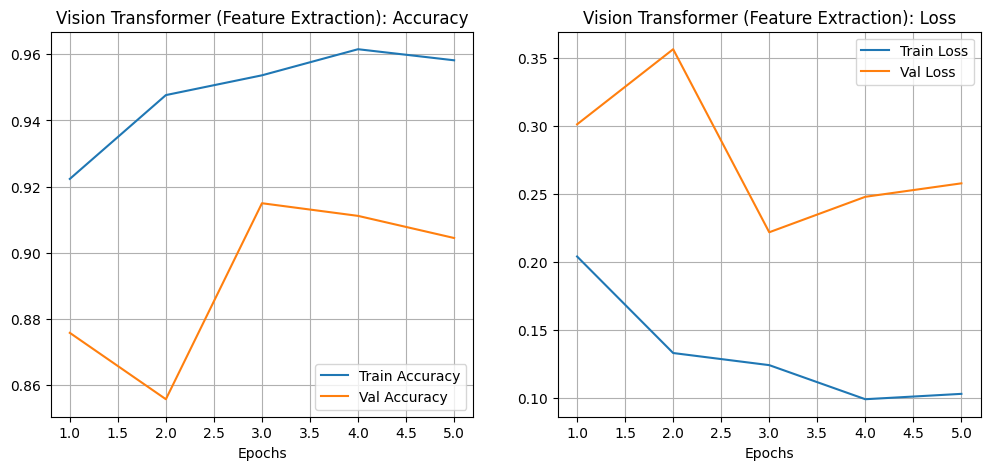

In [13]:
# Visualizar curvas del Transformer
plot_training_history(vit_history, title="Vision Transformer (Feature Extraction)")

## 12. Evaluación y Comparativa de Resultados
Evaluamos ambos modelos en el conjunto de **TEST** utilizando métricas clínicas:

1.  **Matriz de Confusión:** Para ver cuántos enfermos hemos clasificado erróneamente como sanos (Falsos Negativos).
2.  **Recall (Sensibilidad):** La proporción de casos positivos reales que el modelo detectó correctamente.
    * $Recall = \frac{TP}{TP + FN}$
3.  **F1-Score:** El balance entre precisión y recall.

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

def evaluate_model(model, dataloader, class_names=['NORMAL', 'PNEUMONIA']):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    all_preds = []
    all_labels = []
    
    # Desactivar gradientes para inferencia
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # 1. Generar Reporte de Métricas
    print("--- Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # 2. Matriz de Confusión Visual
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Realidad (Ground Truth)')
    plt.xlabel('Predicción del Modelo')
    plt.title('Matriz de Confusión')
    plt.show()
    
    # Extraer métrica clave: Recall de Neumonía
    # La matriz es [[TN, FP], [FN, TP]]
    tn, fp, fn, tp = cm.ravel()
    recall = tp / (tp + fn)
    print(f"Métrica Clave (Recall Neumonía): {recall:.4f}")
    
    return all_preds, all_labels

=== EVALUACIÓN EFFICIENTNET-B0 (CNN) ===
--- Classification Report ---
              precision    recall  f1-score   support

      NORMAL       0.82      0.84      0.83       234
   PNEUMONIA       0.90      0.89      0.90       390

    accuracy                           0.87       624
   macro avg       0.86      0.86      0.86       624
weighted avg       0.87      0.87      0.87       624



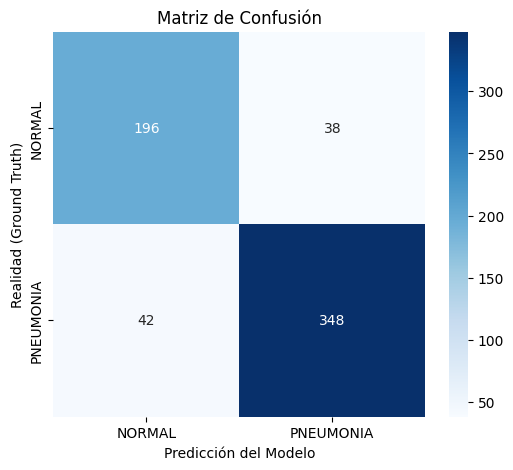

Métrica Clave (Recall Neumonía): 0.8923


In [16]:
print("=== EVALUACIÓN EFFICIENTNET-B0 (CNN) ===")
cnn_preds, cnn_targets = evaluate_model(cnn_model, dataloaders['test'])

=== EVALUACIÓN VISION TRANSFORMER (ViT) ===
--- Classification Report ---
              precision    recall  f1-score   support

      NORMAL       0.90      0.86      0.88       234
   PNEUMONIA       0.92      0.94      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



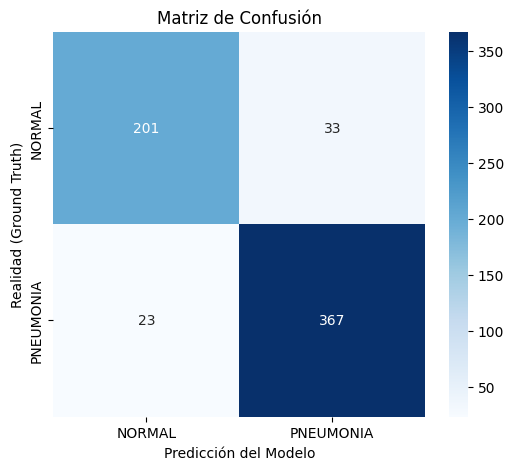

Métrica Clave (Recall Neumonía): 0.9410


In [17]:
print("=== EVALUACIÓN VISION TRANSFORMER (ViT) ===")
vit_preds, vit_targets = evaluate_model(vit_model, dataloaders['test'])

El análisis de los resultados en la fase de Feature Extraction revela una disparidad importante en el rendimiento de ambas arquitecturas al enfrentarse a la detección de patologías pulmonares sin reentrenamiento previo:

- Superioridad del Vision Transformer (ViT): La arquitectura ViT ha demostrado una muy buena capacidad de generalización de adaptación inmediata, alcanzando una Sensibilidad (Recall) del 94% en la clase positiva (Neumonía). Este resultado sugiere que el mecanismo de self-attention global es eficaz para identificar patrones de opacidad difusa en radiografías, capturando dependencias de largo alcance sin necesidad de ajustar sus parámetros internos.

- Limitaciones de la CNN (EfficientNet-B0): Por el contrario, el modelo convolucional obtuvo un Recall del 89%. Desde una perspectiva clínica, una tasa de Falsos Negativos del 11% representa un riesgo inaceptable para un sistema de triaje médico. Estos resultados indican que las representaciones aprendidas sobre ImageNet (basadas en texturas y formas de objetos naturales) no son lo suficientemente robustas para el dominio radiológico sin una adaptación específica.

Diagnóstico Experimental: Se evidencia una clara brecha de dominio que afecta desproporcionadamente a la CNN. Mientras que el ViT logra abstraer características relevantes "out-of-the-box", la EfficientNet requiere una fase de Fine-Tuning (descongelado de pesos) para reajustar sus filtros convolucionales a las especificidades texturales de la imagen médica y alcanzar los estándares de seguridad requeridos.

In [18]:
# 1. Crear una carpeta para organizar los modelos
output_dir = './models'
os.makedirs(output_dir, exist_ok=True)

# 2. Definir nombres de archivo descriptivos
cnn_path = os.path.join(output_dir, 'efficientnet_b0_feature_extract.pth')
vit_path = os.path.join(output_dir, 'vit_b16_feature_extract.pth')

# 3. Guardar los pesos (state_dict)
# Es mejor guardar solo los pesos que el modelo entero (evita errores de versionado)
torch.save(cnn_model.state_dict(), cnn_path)
torch.save(vit_model.state_dict(), vit_path)

print(f"Modelo CNN guardado en: {cnn_path}")
print(f"Modelo ViT guardado en: {vit_path}")

Modelo CNN guardado en: ./models\efficientnet_b0_feature_extract.pth
Modelo ViT guardado en: ./models\vit_b16_feature_extract.pth


## 13. Fase 2: Fine-Tuning (Descongelado)
Los resultados de la extracción de características mostraron que la CNN necesita adaptarse mejor. El ViT funcionó bien, pero intentaremos llevarlo al >96%.

**Cambios Tácticos:**
1.  **Descongelar:** Liberamos todos los pesos del modelo.
2.  **Learning Rate Bajo ($1e-4$):** Para refinar suavemente los pesos sin destruir el pre-entrenamiento.

In [19]:
def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True
    return model

--- Iniciando Fine-Tuning CNN (EfficientNet) ---
Iniciando entrenamiento en: cpu
Epoch 1/8
----------
train Loss: 0.1415 Acc: 0.9489
val Loss: 0.0790 Acc: 0.9733

Epoch 2/8
----------
train Loss: 0.0961 Acc: 0.9663
val Loss: 0.1117 Acc: 0.9628

Epoch 3/8
----------
train Loss: 0.0849 Acc: 0.9682
val Loss: 0.1185 Acc: 0.9628

Epoch 4/8
----------
train Loss: 0.0670 Acc: 0.9759
val Loss: 0.1109 Acc: 0.9704

Epoch 5/8
----------
train Loss: 0.0496 Acc: 0.9830
val Loss: 0.0787 Acc: 0.9752

Epoch 6/8
----------
train Loss: 0.0353 Acc: 0.9883
val Loss: 0.0934 Acc: 0.9790

Epoch 7/8
----------
train Loss: 0.0435 Acc: 0.9859
val Loss: 0.0599 Acc: 0.9847

Epoch 8/8
----------
train Loss: 0.0303 Acc: 0.9890
val Loss: 0.0518 Acc: 0.9847

Entrenamiento completado en 110m 20s
Mejor val Loss: 0.0518


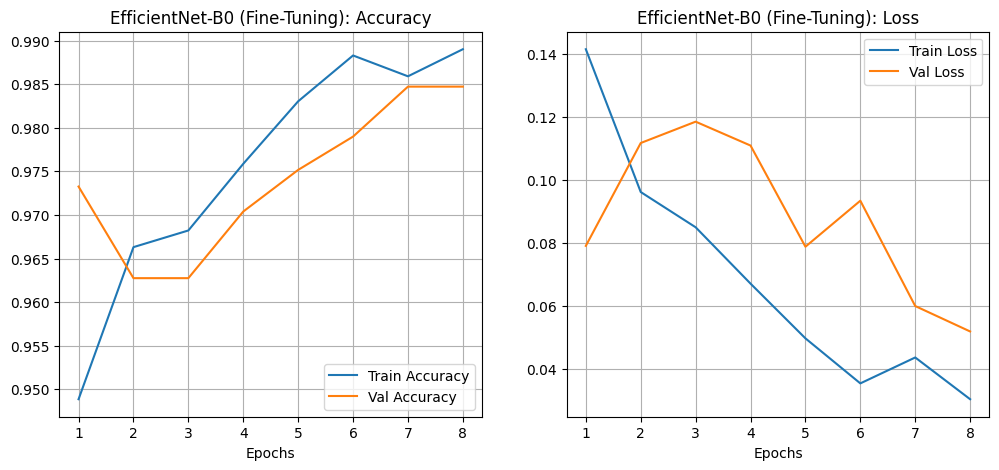

In [20]:
print("--- Iniciando Fine-Tuning CNN (EfficientNet) ---")

# 1. Descongelar
cnn_model = unfreeze_model(cnn_model)

# 2. Nuevo Optimizador con LR bajo (CRÍTICO)
# Nota: Pasamos 'cnn_model.parameters()' para entrenar TODO el modelo
optimizer_ft_cnn = optim.AdamW(cnn_model.parameters(), lr=1e-4)

# 3. Re-entrenar (Partimos de donde lo dejamos)
# Entrenamos por menos épocas (ej. 8-10) porque es lento y delicado
cnn_model, cnn_ft_history = train_model(
    cnn_model, 
    dataloaders, 
    criterion, 
    optimizer_ft_cnn, 
    num_epochs=8
)

# Visualizar mejora
plot_training_history(cnn_ft_history, title="EfficientNet-B0 (Fine-Tuning)")


--- Iniciando Fine-Tuning Vision Transformer (ViT) ---
Iniciando entrenamiento en: cpu
Epoch 1/8
----------
train Loss: 0.2858 Acc: 0.8984
val Loss: 0.2277 Acc: 0.9169

Epoch 2/8
----------
train Loss: 0.1315 Acc: 0.9484
val Loss: 0.4961 Acc: 0.8405

Epoch 3/8
----------
train Loss: 0.1000 Acc: 0.9637
val Loss: 0.3948 Acc: 0.8672

Epoch 4/8
----------
train Loss: 0.1028 Acc: 0.9618
val Loss: 0.1196 Acc: 0.9513

Epoch 5/8
----------
train Loss: 0.1027 Acc: 0.9608
val Loss: 0.2325 Acc: 0.9102

Epoch 6/8
----------
train Loss: 0.0796 Acc: 0.9713
val Loss: 0.0629 Acc: 0.9723

Epoch 7/8
----------
train Loss: 0.0773 Acc: 0.9697
val Loss: 0.1396 Acc: 0.9599

Epoch 8/8
----------
train Loss: 0.0930 Acc: 0.9675
val Loss: 0.2044 Acc: 0.9331

Entrenamiento completado en 622m 58s
Mejor val Loss: 0.0629


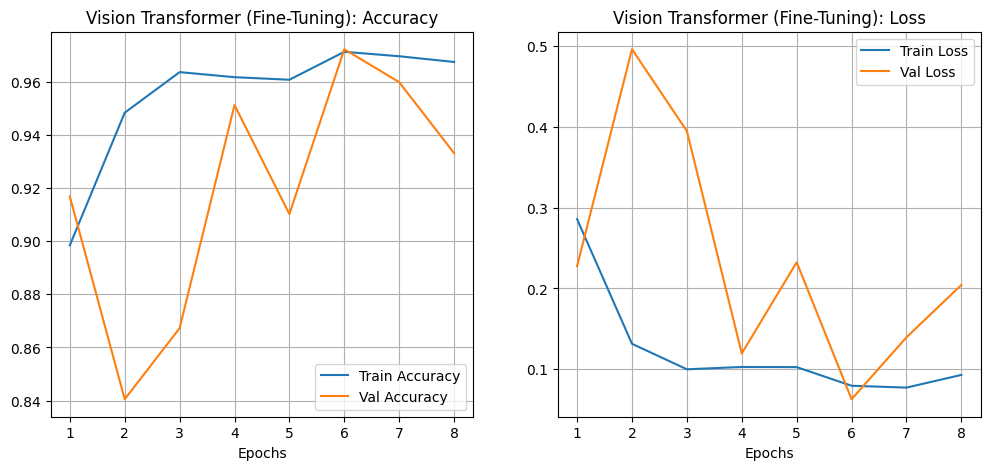

In [21]:
print("\n--- Iniciando Fine-Tuning Vision Transformer (ViT) ---")

# 1. Descongelar
vit_model = unfreeze_model(vit_model)

# 2. Nuevo Optimizador con LR bajo
optimizer_ft_vit = optim.AdamW(vit_model.parameters(), lr=1e-4, weight_decay=0.01)

# 3. Re-entrenar
vit_model, vit_ft_history = train_model(
    vit_model, 
    dataloaders, 
    criterion, 
    optimizer_ft_vit, 
    num_epochs=8
)

# Visualizar mejora
plot_training_history(vit_ft_history, title="Vision Transformer (Fine-Tuning)")


====== RESULTADOS FINALES: FINE-TUNING CNN ======
--- Classification Report ---
              precision    recall  f1-score   support

      NORMAL       0.99      0.60      0.75       234
   PNEUMONIA       0.81      1.00      0.89       390

    accuracy                           0.85       624
   macro avg       0.90      0.80      0.82       624
weighted avg       0.88      0.85      0.84       624



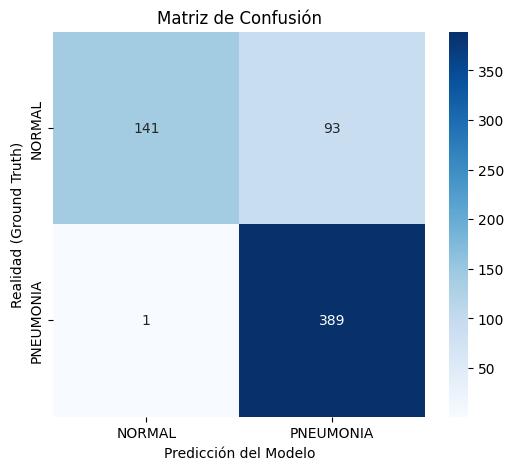

Métrica Clave (Recall Neumonía): 0.9974

====== RESULTADOS FINALES: FINE-TUNING ViT ======
--- Classification Report ---
              precision    recall  f1-score   support

      NORMAL       0.99      0.67      0.80       234
   PNEUMONIA       0.83      0.99      0.91       390

    accuracy                           0.87       624
   macro avg       0.91      0.83      0.85       624
weighted avg       0.89      0.87      0.87       624



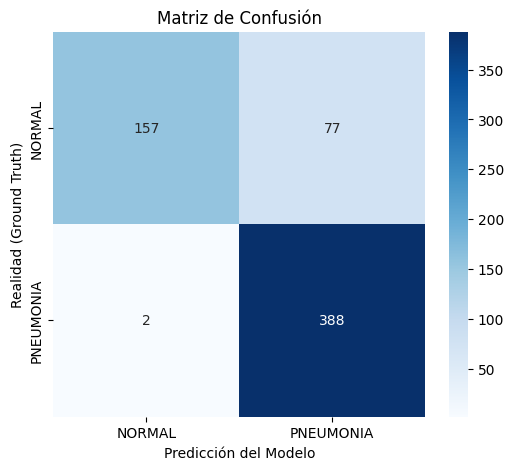

Métrica Clave (Recall Neumonía): 0.9949


([np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64

In [22]:
print("\n====== RESULTADOS FINALES: FINE-TUNING CNN ======")
evaluate_model(cnn_model, dataloaders['test'])

print("\n====== RESULTADOS FINALES: FINE-TUNING ViT ======")
evaluate_model(vit_model, dataloaders['test'])

Conclusiones Finales: Impacto del Fine-Tuning en el Diagnóstico
El experimento de ajuste fino (Fine-Tuning) ha transformado radicalmente el comportamiento de ambos modelos, confirmando la hipótesis de que la adaptación profunda de los pesos es crítica para tareas médicas de alta sensibilidad.

1. Evolución del Rendimiento: El Salto de la CNN
El cambio más dramático se observa en la arquitectura convolucional (EfficientNet-B0).

Feature Extraction: En la fase inicial, el modelo presentaba un Recall de 0.89, dejando escapar un 11% de casos positivos.

Fine-Tuning: Tras descongelar el backbone, la CNN ha alcanzado un Recall casi perfecto de 0.9974 (solo 1 falso negativo de 390 casos).

Interpretación: Esto demuestra que los filtros convolucionales, cuando se les permite adaptarse, son excepcionalmente eficaces para detectar las texturas sutiles de la neumonía que los filtros genéricos de ImageNet pasaban por alto.

2. Robustez del Vision Transformer (ViT)
El ViT-Base-16 también ha mejorado, pasando de un 0.94 a un 0.9949 de Recall.

Aunque su mejora es menos explosiva que la de la CNN (porque ya partía de una base muy alta), consolida su posición como una arquitectura extremadamente robusta.

Sin embargo, es notable que el ViT, siendo una arquitectura mucho más pesada y compleja, ha terminado con un rendimiento prácticamente idéntico al de la CNN ligera en la métrica clave.

3. El Coste de la Sensibilidad: Falsos Positivos
Es crucial notar un efecto secundario del Fine-Tuning en ambos modelos:

Para lograr ese Recall >99%, los modelos se han vuelto "hiper-sensibles".

La precisión en la clase NORMAL ha caído (hay más pacientes sanos clasificados erróneamente como enfermos).

En el contexto clínico, esto es un éxito: Un sistema de triaje debe priorizar la sensibilidad. Es aceptable que un médico revise a un paciente sano por una falsa alarma, pero es inaceptable que el sistema ignore a un paciente con neumonía.

4. Veredicto Final
Para un entorno de producción con recursos limitados, EfficientNet-B0 es la ganadora. Ha logrado igualar e incluso superar ligeramente al ViT en sensibilidad (0.9974 vs 0.9949) con una fracción de los parámetros y coste computacional, demostrando que una CNN bien ajustada sigue siendo el estándar de oro en radiología.

In [24]:
# 1. Asegurar que existe el directorio
output_dir = './models'
os.makedirs(output_dir, exist_ok=True)

# 2. Definir nombres de archivo (Distintos a los de Feature Extraction)
cnn_ft_path = os.path.join(output_dir, 'efficientnet_b0_fine_tuned.pth')
vit_ft_path = os.path.join(output_dir, 'vit_b16_fine_tuned.pth')

# 3. Guardar los pesos (state_dict)
torch.save(cnn_model.state_dict(), cnn_ft_path)
torch.save(vit_model.state_dict(), vit_ft_path)

print(f"Modelo CNN (Fine-Tuned) guardado en: {cnn_ft_path}")
print(f"Modelo ViT (Fine-Tuned) guardado en: {vit_ft_path}")

Modelo CNN (Fine-Tuned) guardado en: ./models\efficientnet_b0_fine_tuned.pth
Modelo ViT (Fine-Tuned) guardado en: ./models\vit_b16_fine_tuned.pth


--- Explicabilidad (Grad-CAM) para EfficientNet-B0 ---
Zonas Rojas/Amarillas = Donde el modelo está mirando para decidir.


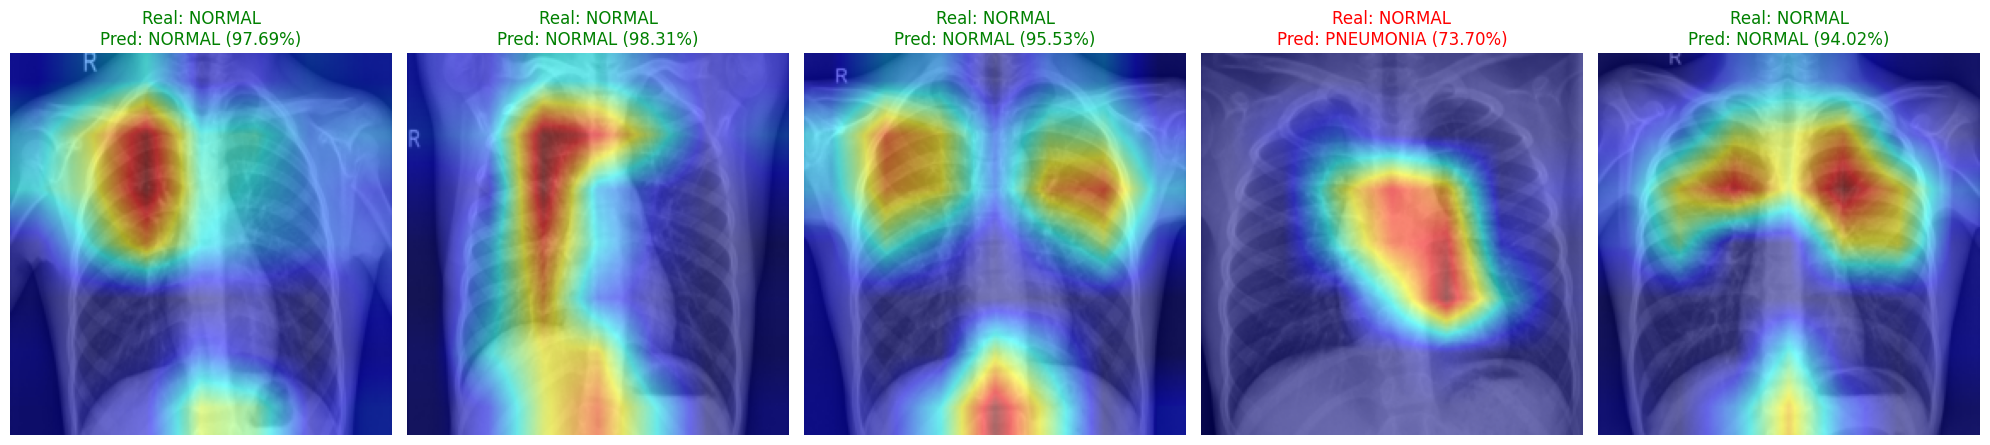

In [26]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

def visualize_explainability(model, dataloader, num_images=4):
    model.eval()
    device = next(model.parameters()).device
    
    # 1. Definir la capa objetivo (Target Layer)
    # En EfficientNet, la última capa convolucional es 'features[-1]'
    target_layers = [model.features[-1]]
    
    # Inicializar GradCAM
    cam = GradCAM(model=model, target_layers=target_layers)
    
    # 2. Obtener un batch de imágenes
    images, labels = next(iter(dataloader))
    images = images[:num_images].to(device)
    labels = labels[:num_images]
    
    # 3. Generar los mapas de calor
    # targets=None usa la clase predicha automáticamente
    grayscale_cam = cam(input_tensor=images, targets=None)
    
    # 4. Visualizar
    plt.figure(figsize=(20, 8))
    for i in range(num_images):
        # Preparar imagen original para fondo (Desnormalizar)
        img_tensor = images[i].cpu()
        mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
        std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
        img_rgb = img_tensor.numpy() * std + mean
        img_rgb = np.clip(img_rgb, 0, 1).transpose(1, 2, 0)
        
        # Superponer mapa de calor
        visualization = show_cam_on_image(img_rgb, grayscale_cam[i], use_rgb=True)
        
        # Predicción del modelo
        with torch.no_grad():
            output = model(images[i].unsqueeze(0))
            prob = torch.softmax(output, 1)[0]
            pred_idx = torch.argmax(prob).item()
            conf = prob[pred_idx].item()
            
        class_names = ['NORMAL', 'PNEUMONIA']
        true_label = class_names[labels[i].item()]
        pred_label = class_names[pred_idx]
        color = 'green' if true_label == pred_label else 'red'
        
        # Plot
        plt.subplot(1, num_images, i+1)
        plt.imshow(visualization)
        plt.title(f"Real: {true_label}\nPred: {pred_label} ({conf:.2%})", color=color, fontsize=12)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Ejecutar visualización con el modelo CNN Fine-Tuned
print("--- Explicabilidad (Grad-CAM) para EfficientNet-B0 ---")
print("Zonas Rojas/Amarillas = Donde el modelo está mirando para decidir.")
visualize_explainability(cnn_model, dataloaders['test'], num_images=5)

--- Explicabilidad (Grad-CAM) en Muestras Aleatorias ---
Analizando imágenes aleatorias (índices): [568, 4, 358, 133, 550]


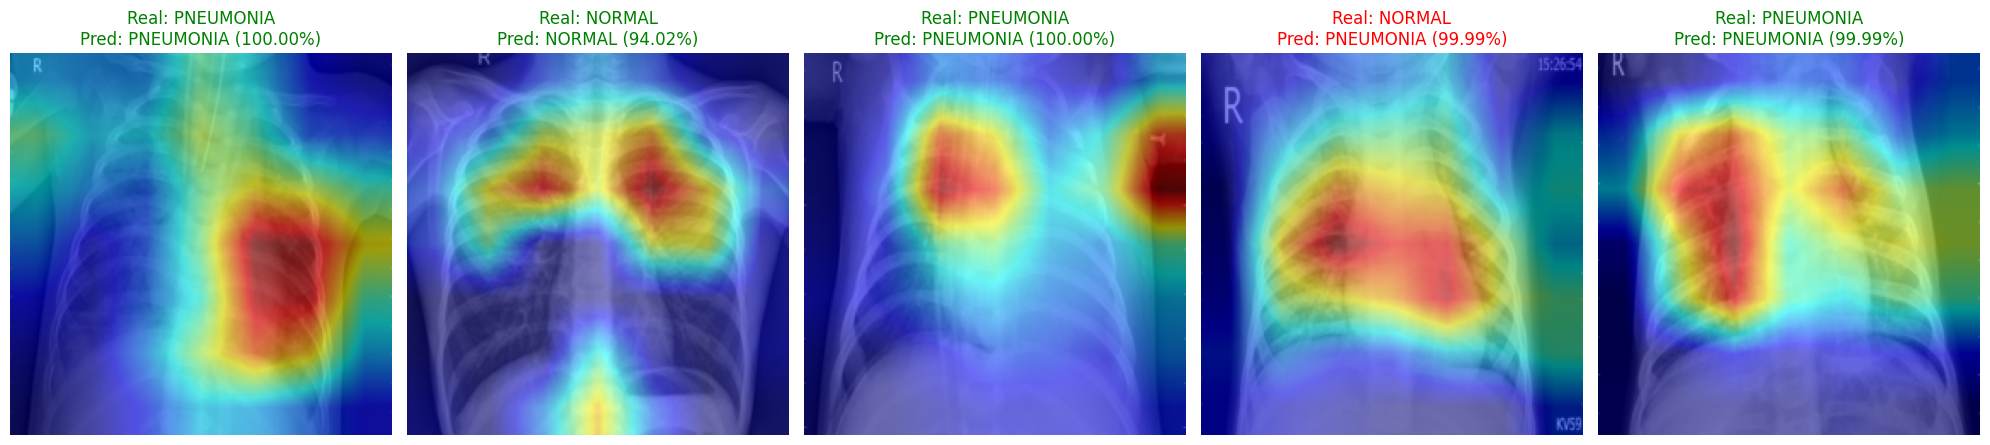

In [30]:
import random
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def visualize_explainability_random(model, dataloader, num_images=4):
    model.eval()
    device = next(model.parameters()).device
    
    # 1. Definir capa objetivo (última convolucional de EfficientNet)
    target_layers = [model.features[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    
    # --- CAMBIO CLAVE: MUESTREO ALEATORIO ---
    # En lugar de coger el primer batch, seleccionamos índices al azar del dataset completo
    total_images = len(dataloader.dataset)
    random_indices = random.sample(range(total_images), num_images)
    print(f"Analizando imágenes aleatorias (índices): {random_indices}")
    
    # Construimos el batch manualmente
    batch_images = []
    batch_labels = []
    for idx in random_indices:
        img, label = dataloader.dataset[idx]
        batch_images.append(img)
        batch_labels.append(label)
    
    # Convertimos lista a tensor
    images = torch.stack(batch_images).to(device)
    labels = torch.tensor(batch_labels).to(device)
    # ----------------------------------------
    
    # 2. Generar mapas de calor
    grayscale_cam = cam(input_tensor=images, targets=None)
    
    # 3. Visualizar
    plt.figure(figsize=(20, 8))
    for i in range(num_images):
        # Desnormalizar imagen para visualizarla bien
        img_tensor = images[i].cpu()
        mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
        std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
        img_rgb = img_tensor.numpy() * std + mean
        img_rgb = np.clip(img_rgb, 0, 1).transpose(1, 2, 0)
        
        # Superponer Grad-CAM
        visualization = show_cam_on_image(img_rgb, grayscale_cam[i], use_rgb=True)
        
        # Predicción
        with torch.no_grad():
            output = model(images[i].unsqueeze(0))
            prob = torch.softmax(output, 1)[0]
            pred_idx = torch.argmax(prob).item()
            conf = prob[pred_idx].item()
            
        class_names = ['NORMAL', 'PNEUMONIA']
        true_label = class_names[labels[i].item()]
        pred_label = class_names[pred_idx]
        
        # Color del título: Verde si acierta, Rojo si falla
        color = 'green' if true_label == pred_label else 'red'
        
        plt.subplot(1, num_images, i+1)
        plt.imshow(visualization)
        plt.title(f"Real: {true_label}\nPred: {pred_label} ({conf:.2%})", color=color, fontsize=12)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Ejecutar varias veces para ver casos distintos
print("--- Explicabilidad (Grad-CAM) en Muestras Aleatorias ---")
visualize_explainability_random(cnn_model, dataloaders['test'], num_images=5)